### Capstone I
**Goal**: The goal of this project is to identify the features that compose the best binary classification model. I will be comparing the performance of several classification algorithm by training different classifiers, specifically Naive Bayes, Support Vector Machines, Logistic Regression, K Nearest Neighbors, and Decision Trees, to detect suicide ideation from social media posts. 

The data is sourced from Kaggle 


link: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch 
- The data are a collection of posts collected from the 'SuicideWatch' and 'teenagers' subreddits from the Reddit platform using PushshiftAPI. Posts were created between 16 December 2008 - 2 January 2021
- Social media posts collected from the 'SuicideWatch' subreddit are labelled 'suicide', while posts collected from 'teenagers' are labelled 'non-suicide'

## !!! Simplify question, define business and data problem 
- Want to have real world impact, actions and things
- Understanding and recognition, form, semantic parsing/logical form?
- Interpreattion of results HOW? Visualization? 
- Consider having one notebook per model
- Grade: last submission 

#### Import and Setup

In [268]:
import nltk
import time
import string
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords 
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

sns.set_style("whitegrid")
sns.set_palette("rocket")
warnings.simplefilter(action='ignore')

In [79]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/lois/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Overview 
The data task is to train various binary text classifiers that detect suicide ideation from social media posts.


**Data Overview** 
- No missing values in the data
- 232074 samples/rows 
- 3 columns: 
       1. Unnamed: 0: A unique ID for each row 
       2. text: Content of the social media post
       3. class: Whether the poster is suicidal or not; values: ['suicide', 'non-suicide']

In [279]:
suicide = pd.read_csv("/Users/Lois/Downloads/ML ipynb/Capstone/SuicideDetection.csv")

In [280]:
print(suicide.shape)
suicide.head()

(232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [281]:
#using a random sample of 20,000 entries for classification
suicide = suicide.sample(20000, random_state = 42)

In [282]:
#sample suicidal post
print('Class:', suicide['class'].iloc[0])
suicide['text'].iloc[0]

Class: suicide


"I Don't know?7? Months self harm free and the urge just gets stronger and stronger every day. The past few days I've just been shit... \nMy family stresses me out especially my nephew (he's 12) My mum has full custody of him and he's told me to go kill myself numerous times.. I wish it was that easy.\nMy partners family stresses me out especially over the past few days. \nStress is my trigger \nI just want to scream and cry. \nI live near the woods so I could go out and scream till I can't possibly scream anymore but the cops will probably get called...\nMy OH knows about my depression but he doesn't really know how I'm feeling at the moment. He would want to come over and make sure I'm OK but he's fucking annoying. He annoys me all the time by doing small stupid things. \nI don't even know where I'm going with the post? \n\n"

In [283]:
#sample non-suicidal post
print('Class:', suicide['class'].iloc[1])
suicide['text'].iloc[1]

Class: non-suicide


'I HAVE TO START BECOMING RICH I HAVE TO START MY COMPANY SO WHEN I BECOME 16 I CAN AFFORD A BIG VAN AND GO ON TRIPS WITH MY FRIENDS BUT I HAVE NO TIME LEFT I HAVE TO START WORKING'

#### Exploratory Data Analysis

In [284]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 74414 to 89712
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   text        20000 non-null  object
 2   class       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


In [285]:
#no null values
suicide.isna().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [286]:
#summary statistics
suicide['char_count'] = suicide.text.apply(len)
print('Mean character count:', suicide['char_count'].mean())
print('Min character count:', suicide['char_count'].min())
print('Max character count:', suicide['char_count'].max())

Mean character count: 680.14645
Min character count: 7
Max character count: 40106


(0.0, 10000.0)

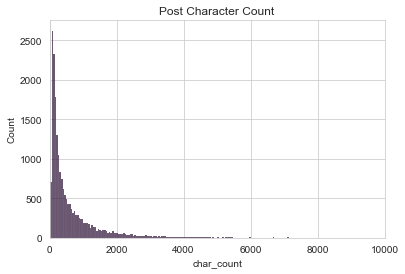

In [287]:
fig, ax = plt.subplots()
sns.histplot(suicide['char_count'], ax = ax).set_title('Post Character Count')
ax.set_xlim(0, 10000)

In [288]:
#most frequent words in both classes 
suicide_words = list(suicide[suicide['class'] == 'suicide'].text.values)
non_suicide_words = list(suicide[suicide['class'] == 'non-suicide'].text.values)

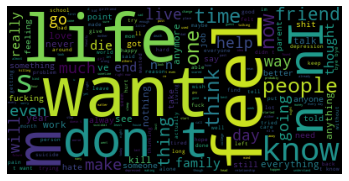

In [289]:
#suicide word cloud 
s_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(suicide_words))
plt.imshow(s_wordcloud)
plt.axis('off')
plt.show()

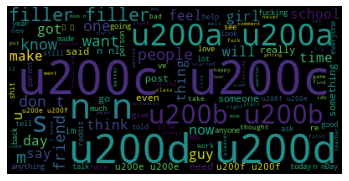

In [290]:
#non-suicide word cloud 
x_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(non_suicide_words))
plt.imshow(x_wordcloud)
plt.axis('off')
plt.show()

The data is balanced: Comparable counts of suicide vs non-suicide posts

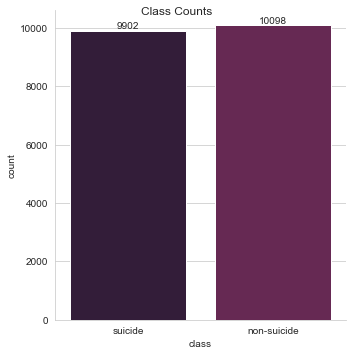

In [291]:
#checking class distribution 

fig = sns.catplot(x = 'class', kind = 'count', data = suicide)
fig.fig.suptitle("Class Counts")
for fig in fig.axes.flat:
    fig.bar_label(fig.containers[0])

#### Data Setup

In [292]:
#only keeping the text and class columns
suicide.drop("Unnamed: 0", axis = 1, inplace = True)

#renaming "class" column as "suicide"
suicide.rename({"class" : "suicide"}, axis = 1, inplace = True)

#numerically representing the contents of "suicide" column
suicide.replace({"suicide" : 1, "non-suicide" : 0}, inplace = True)
suicide.head()

,text,suicide,char_count
74414,I Don't know?7? Months self harm free and the ...,1,828
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0,179
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0,96
14043,I've honestly got no idea what to do anymore.I...,1,1089
30673,Do you ever just cry? Like you just think abou...,0,268


In [307]:
#train test split
X = suicide['text']
y = suicide['suicide']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#### Text Preprocessing

In [203]:
#punctuation removal
#def remove_punctuation(text):
    #no_punctuation = ''.join([i for i in text if i not in string.punctuation])
    #return no_punctuation

In [204]:
#suicide['text'] = suicide['text'].apply(lambda x : remove_punctuation(x))

In [311]:
#tokenization, stemming, stop word removal, lower casing 
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    
    proprocessed_text = []
    for entry in text:
        tokens = tokenizer.tokenize(entry)
        proprocessed_text.append([word for word in tokens if word not in swords])
    return proprocessed_text

In [312]:
pX_train = preprocess_text(X_train)

In [313]:
pX_test = preprocess_text(X_test)

In [317]:
#checking output 
X_train.iloc[0]

'First gun last gunBuying my first gun tomorrow. Should have no problems. Hopefully will get the courage to use it in the next couple of days. No more overdoses. No more medical bills. No more no more no more'

In [319]:
#checking output
pX_train[0]

['first',
 'gun',
 'last',
 'gunbuying',
 'first',
 'gun',
 'tomorrow',
 '.',
 'problems',
 '.',
 'hopefully',
 'get',
 'courage',
 'use',
 'next',
 'couple',
 'days',
 '.',
 'overdoses',
 '.',
 'medical',
 'bills',
 '.']

#### Feature Engineering 
Comparing Count Vectorizer (Bag of Words) vs TF-IDF on stemmed words

In [320]:
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stem(text):
    return (stemmer.stem(w) for w in analyzer(text))

In [321]:
#grid search dict
cvect_params = {'cv__max_features': [100, 500, 1000, 2000],
                'cv__stop_words': ['english', None],
                'cv__analyzer': ['word', stem]}

tf_params = {'tfidf__max_features': [100, 500, 1000, 2000],
             'tfidf__stop_words': ['english', None],
             'tfidf__analyzer' : ['word', stem]}

#### Model Comparison
**Multinomial Naïve Bayes** 

In [ ]:
#logreg + bow 
lgr_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('lgr', LogisticRegression())
])


#gridsearch stopwords and max features 
lgr_cv_grid = RandomizedSearchCV(estimator = lgr_cv,
                   param_distributions = cvect_params)

start = time.time()
lgr_cv_grid.fit(X_train, y_train)
stop = time.time()

#stats
lgr_cv_time = stop - start
lgr_cv_params = lgr_cv_grid.best_params_
lgr_cv_acc = lgr_cv_grid.score(X_test, y_test)

In [ ]:
#logreg + tfidf 
lgr_tf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgr', LogisticRegression())
])

#gridsearch stopwords and max features 
lgr_tf_grid = RandomizedSearchCV(estimator = lgr_tf,
                   param_distributions = tf_params)

#fit
start = time.time()
lgr_tf_grid.fit(X_train, y_train)
stop = time.time()

#stats
lgr_tf_time = stop - start
lgr_tf_acc = lgr_tf_grid.score(X_test, y_test)
lgr_tf_params = lgr_tf_grid.best_params_

**Logistic Regression**